# **A Tour of the pyclep package's Ion class**

In [1]:
import pycelp 
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["XUVTOP"] = '/usr/local/ssw/packages/chianti/dbase/'

## Initializing an Ion Object for a particular Ion 

- The primary class used for calculations with pyCELP is the Ion class.  It is automatically imported into the main package from the pyclep.ion sub-module.  With it, one can load the data for a single ion and perform calculations relevant to synthesizing the polarized emission.

- Let's start by initializing a class for the Fe XIII ion.  We aim to explore the 1074.6 and 1079.8 nm coronal emission lines.  When you initialize the Ion class, pycelp will read the chianti database for the given atom.  The default to is read all level and collisional information available.  For the Fe XIII ion, there are 749 energy levels.  Once the data is read, pyclep will then pre-calculate as many terms (or factors) in the statistical equilbrium equations as possible.  This includes all calculates of the relevant wigner coefficients.  As such, the initialization can take some time.  

- Here we will restrict the number of levels we use in our calculations to make it faster.  It is up to the user to decide how many levels are appropriate for a given atom.  See Schad & Dima (2020) for more details.  

In [2]:
fe13 = pycelp.Ion('fe_13',nlevels = 50)

 reading:  /usr/local/ssw/packages/chianti/dbase/fe/fe_13/fe_13.elvlc
 reading:  /usr/local/ssw/packages/chianti/dbase/fe/fe_13/fe_13.wgfa
 reading:  /usr/local/ssw/packages/chianti/dbase/fe/fe_13/fe_13.scups
 reading:  /usr/local/ssw/packages/chianti/dbase/fe/fe_13/fe_13.psplups
 using default abundances: /usr/local/ssw/packages/chianti/dbase/abundance/sun_photospheric_2009_asplund.abund
 reading:  /usr/local/ssw/packages/chianti/dbase/abundance/sun_photospheric_2009_asplund.abund
 testing default file: /usr/local/ssw/packages/chianti/dbase/ioneq/chianti.ioneq
 reading:  /usr/local/ssw/packages/chianti/dbase/ioneq/chianti.ioneq
 setting up electron collision rate factors
 setting up proton  collision rate factors
 setting up non-dipole radiative rate factors
 getting non-dipole rate factors
 setting up dipole radiative rate factors


<div class="alert alert-info" role="alert">
    <div class="row vertical-align">
        <div class="col-xs-1 text-center">
            <i class="fa fa-exclamation-triangle fa-2x"></i>
        </div>
        <div class="col-xs-11">
                <strong>Note:</strong>  If this is your first time running pycelp, initization may take longer.  pycelp uses numba @njit compilation with caching enabled.  Once the various functions are run one, the compiled functions will be in the memory for this session and available in the cache for later.  Thus, subsequent executions will be much faster.                  
        </div>   
    </div> 
</div>


Now, we can view the representation of the Ion by simplying return the class instance name directly

In [3]:
fe13

pyCELP Ion class
    ---------------------
    Ion Name: fe_13
    Number of energy levels included: 50
    Number of SEE equations: 142
    Number of Radiative Transitions: 366
    Ionization Equilbrium Filename: /usr/local/ssw/packages/chianti/dbase/ioneq/chianti.ioneq

We see that there at 50 energy levels included.  The number of statistical equilbrium equations is 142; thus, the rate matrix will be 142 x 142 in size.  The number of radiative transitions included is 366. 

We can look at the first 10 radiative transitions using the show_lines method. 

In [4]:
fe13.show_lines(10)

 Index -- WV_VAC [A] -- WV_AIR [A] -- TRANSITION
0 10749.105 10746.153 3s2 3p2 3P1  -->  3s2 3p2 3P0
1 10800.77 10797.804 3s2 3p2 3P2  -->  3s2 3p2 3P1
2 5387.438 5385.939 3s2 3p2 3P2  -->  3s2 3p2 3P0
3 2579.54 2578.768 3s2 3p2 1D2  -->  3s2 3p2 3P1
4 3388.911 3387.939 3s2 3p2 1D2  -->  3s2 3p2 3P2
5 2080.313 2079.65 3s2 3p2 1D2  -->  3s2 3p2 3P0
6 1370.815 1370.815 3s2 3p2 1S0  -->  3s2 3p2 3P2
7 2301.957 2301.248 3s2 3p2 1S0  -->  3s2 3p2 1D2
8 1216.428 1216.428 3s2 3p2 1S0  -->  3s2 3p2 3P1
9 600.405 600.405 3s 3p3 5S2  -->  3s2 3p2 1D2


### Access to raw Chianti Database Information

- Most variables in the Ion class are currently in public scope.  For example, the level information read from Chianti is in the dictionary elvl_data.  We can look at the available the keys here.  pycelp uses much of this information for its calculations but it does not typically use this dictionary directly.  Reading the Ion class source code can helpful if interested

- Similar dictionaries are available for the radiation transitions (wgfa_data), electron collisional data (scups_data), and proton collisional data (splups_data). 

In [5]:
print(' elvl_data keys:')
print(fe13.elvl_data.keys())
print(' ')
print(' Chianti level index  ---   energy [' + fe13.elvl_data['energy_units'] + '] --- level configuration') 
print(' ... printing for first 5 levels')
for lev in range(5):
    print(fe13.elvl_data['index'][lev],' ',fe13.elvl_data['energy'][lev],'  ',fe13.elvl_data['full_level'][lev])

 elvl_data keys:
dict_keys(['ion_name', 'ion_z', 'ion_n', 'filename', 'version', 'reference', 'index', 'conf', 'conf_latex', 'conf_index', 'term', 'term_latex', 'level', 'level_latex', 'full_level', 'full_level_latex', 'label', 'mult', 's', 'l', 'l_sym', 'j', 'j_str', 'parity', 'parity_str', 'weight', 'obs_energy', 'theory_energy', 'energy', 'energy_units'])
 
 Chianti level index  ---   energy [cm^-1] --- level configuration
 ... printing for first 5 levels
1   0.0    3s2 3p2 3P0
2   9303.1    3s2 3p2 3P1
3   18561.699    3s2 3p2 3P2
4   48069.699    3s2 3p2 1D2
5   91511.0    3s2 3p2 1S0


#### Converting to pandas dataframe

- If you have pandas installed, you can also view the level information and the radiative transition information as a dataframe as follows:

In [6]:
energy_levels_df = fe13.energy_levels_to_dataframe()
energy_levels_df[0:10]  ## show first ten levels only 

,Index,Ion_name,Ion_z,Config,Conf Idx,Term,Level,Full Level,Spin Mult,S,L,Orbital,J,Lande g,Parity,Parity Str,Stat. Weight,Obs Energy [cm^-1],Theory Energy [cm^-1],Energy [cm^-1]
0,1,fe_13,26,3s2 3p2,1,3P,3P0,3s2 3p2 3P0,3,1.0,1,P,0.0,0.000000,0,e,1.0,0.000,0.0,0.000
1,2,fe_13,26,3s2 3p2,1,3P,3P1,3s2 3p2 3P1,3,1.0,1,P,1.0,1.500000,0,e,3.0,9303.100,9303.0,9303.100
2,3,fe_13,26,3s2 3p2,1,3P,3P2,3s2 3p2 3P2,3,1.0,1,P,2.0,1.500000,0,e,5.0,18561.699,18562.0,18561.699
3,4,fe_13,26,3s2 3p2,1,1D,1D2,3s2 3p2 1D2,1,0.0,2,D,2.0,1.000000,0,e,5.0,48069.699,48070.0,48069.699
4,5,fe_13,26,3s2 3p2,1,1S,1S0,3s2 3p2 1S0,1,0.0,0,S,0.0,0.000000,0,e,1.0,91511.000,91511.0,91511.000
5,6,fe_13,26,3s 3p3,2,5S,5S2,3s 3p3 5S2,5,2.0,0,S,2.0,2.000000,1,o,5.0,214624.000,214624.0,214624.000
6,7,fe_13,26,3s 3p3,2,3D,3D1,3s 3p3 3D1,3,1.0,2,D,1.0,0.500000,1,o,3.0,287205.000,282051.0,287205.000
7,8,fe_13,26,3s 3p3,2,3D,3D2,3s 3p3 3D2,3,1.0,2,D,2.0,1.166667,1,o,5.0,287356.000,282222.0,287356.000
8,9,fe_13,26,3s 3p3,2,3D,3D3,3s 3p3 3D3,3,1.0,2,D,3.0,1.333333,1,o,7.0,290180.000,290180.0,290180.000
9,10,fe_13,26,3s 3p3,2,3P,3P0,3s 3p3 3P0,3,1.0,1,P,0.0,0.000000,1,o,1.0,328927.000,324378.0,328927.000


In [7]:
rad_trans_df = fe13.rad_transitions_to_dataframe()
rad_trans_df[0:10]  ## show first ten transitions only

,Lambda Vac [A],Lambda Air [A],UppLev Idx,LowLev Idx,Upper Level,Lower Level,geff [LS],D coeff,E coeff,Einstein A
0,10749.105137,10746.153423,2,1,3s2 3p2 3P1,3s2 3p2 3P0,1.50,1.000000,1.060660e+00,14.00000
1,10800.770181,10797.804402,3,2,3s2 3p2 3P2,3s2 3p2 3P1,1.50,0.591608,6.274950e-01,9.88000
2,5387.437863,5385.938558,3,1,3s2 3p2 3P2,3s2 3p2 3P0,3.00,-0.000000,-0.000000e+00,0.00637
3,2579.540186,2578.767826,4,2,3s2 3p2 1D2,3s2 3p2 3P1,0.75,0.591608,1.861901e-16,60.30000
4,3388.911482,3387.938955,4,3,3s2 3p2 1D2,3s2 3p2 3P2,1.25,-0.591608,-8.366600e-01,73.70000
5,2080.312589,2079.649941,4,1,3s2 3p2 1D2,3s2 3p2 3P0,2.00,-0.000000,-0.000000e+00,0.00400
6,1370.815054,1370.815054,5,3,3s2 3p2 1S0,3s2 3p2 3P2,3.00,-0.000000,-0.000000e+00,3.76000
7,2301.956841,2301.247695,5,4,3s2 3p2 1S0,3s2 3p2 1D2,2.00,-0.000000,-0.000000e+00,7.84000
8,1216.428105,1216.428105,5,2,3s2 3p2 1S0,3s2 3p2 3P1,1.50,0.000000,-0.000000e+00,970.00000
9,600.404789,600.404789,6,4,3s 3p3 5S2,3s2 3p2 1D2,1.50,-0.591608,9.309503e-17,183000.00000


## Example calculation of the statistical equilibrium

Now, lets do a single calculation of the statistical equilbrium.  The default method for this (currently) is called calc_rho_sym, which excepts an electron density, a temperature, a height above the solar surface and a magnetic field inclination.  The code currently assumes the proton temperature equals the electron temperature.  The proton density is set to 0.85 times the electron density.

In [8]:
edens = 1e8                  ## cm^-3
etemp = fe13.get_maxtemp()   ## Kelvin 
print(' Max temp is : ', etemp, ' log T: ', np.log10(etemp))
ht    = 0.1                   ## solar radius units above the photosphere 
thetab = 0.     ## degrees 
fe13.calc_rho_sym(edens,etemp,ht, thetab, include_limbdark=True, include_protons=True)

 Max temp is :  1676832.9368110066  log T:  6.224489795918367


Having executed the calc_rho_sym method, the statistical equilibrium equations have now been solved and the elements of the atomic density matrix are now available.  The total rate matrix in the spherical tensor representation is given in the see_matrix variables.  Each row of this matrix corresponds to a particular energy level and moment order K, which is recorded in the see_lev and see_k variables. 

In [9]:
print(fe13.see_matrix.shape,fe13.see_lev.shape,fe13.see_k.shape)

(142, 142) (142,) (142,)


One can view the spherical tensor matrix elements directly in the rho variable, which has a shape of (nlevels x the maximum order K). Q = 0 on account of the no coherence hypothesis.  Thus, rho has already been reshaped using the index variables above. Associated with the index variables is an array of weights used to normalize the total populations to unity.  You can check the solution by ensuring the total population is 1 as follows.  A method may be created to do this directly. 

In [10]:
print(' Shape of rho: ',fe13.rho.shape)
## here is where you can calculate the trace of the equations 
print(' sum of populations: ',  np.sum(fe13.rho[:,0]*fe13.weight[fe13.weight != 0]))

 Shape of rho:  (50, 11)
 sum of populations:  1.0000000000000002


## Single Intensity Emission Coefficient Calculation using Ion class method 

At this point we have access to all the information we need to calculate the polarized emission coefficients.

The emission coefficient for Stokes I is given in Equation 3 of Schad & Dima (2020):  https://rdcu.be/b5J2X


$$
\epsilon_I(\lambda,\vec{\Omega}_{0}) = \frac{hv}{4\pi} N_{\alpha_{u} J_{u}}A_{\alpha_{u} J_{u} \rightarrow \alpha_{\ell} J_{\ell}}
     \left[1 + \frac{3}{2\sqrt{2}}D\sigma^2_0\left(\cos^2{\Theta_B} - \frac{1}{3}\right)\right]\phi(\lambda-\lambda_0)
$$

Here we assume the line is not resolved and instead calculate the line-integrated emission coefficient


In [11]:
## select the wavelength of the desired transition (Angstrom in Air) 
wvair = 10747  
epsI = fe13.calc_Iemiss(wvair, thetaBLOS=54.735610317245346)   ## thetaBLOS = Van Vleck angle [default] 
units = r'photons cm$^{-3}$ s$^{-1}$ arcsec$^{-2}$'
print(epsI,' ',units)

2.7604104319375896e-09   photons cm$^{-3}$ s$^{-1}$ arcsec$^{-2}$


## Polarized Emission Coefficient Calculation using Ion class method 

The polarized emission coefficients are given in Equations 6,7, and 8 of  Schad & Dima (2020):  https://rdcu.be/b5J2X

These pertain to a particular geometry where the reference direction of the linear polarization is parallel to the LOS projected magnetic field orientation.   The line profile is given by a normal distribution $\phi$ and its derivative $\phi'$.  Here we only calculate the coefficients.

$$
\epsilon_Q(\lambda,\vec{\Omega}_{0}) =  \frac{3}{2\sqrt{2}}\frac{hv}{4\pi} N_{\alpha_{u} J_{u}}A_{\alpha_{u} J_{u} \rightarrow \alpha_{\ell} J_{\ell}} D\sigma^2_0 \sin^2{\Theta_{B}}{\ }\phi(\lambda-\lambda_0)
$$

$$
\epsilon_U(\lambda,\vec{\Omega}_{0}) = 0
$$

$$
\epsilon_V(\lambda,\vec{\Omega}_{0}) = -\frac{\lambda^{2}}{c}\frac{hv}{4\pi} N_{\alpha_{u} J_{u}}A_{\alpha_{u} J_{u} \rightarrow \alpha_{\ell} J_{\ell}}\cos{\Theta_{B}}\nu_{L}[\bar{g} + E\sigma^2_0]\phi'(\lambda-\lambda_0)
$$

- Or you can get all of the polarized emission coefficients as follows

In [12]:
epsI,epsQ,epsU,epsV = fe13.calc_PolEmissCoeff(10747.,100.,54.735610317245346,0.)
iqu_units = 'photons cm$^{-3}$ s$^{-1}$ arcsec$^{-2}$'
v_units   =  'photons cm$^{-3}$ s$^{-1}$ arcsec$^{-2}$ Angstrom^{-1}'
print(' epsI : ',epsI,'    ',iqu_units)
print(' epsQ : ',epsQ,'    ',iqu_units)
print(' epsU : ',epsU,'    ',iqu_units)
print(' epsV : ',epsV,'    ',v_units)

 epsI :  2.7604104319375896e-09      photons cm$^{-3}$ s$^{-1}$ arcsec$^{-2}$
 epsQ :  1.9093023837349878e-10      photons cm$^{-3}$ s$^{-1}$ arcsec$^{-2}$
 epsU :  0.0      photons cm$^{-3}$ s$^{-1}$ arcsec$^{-2}$
 epsV :  -8.919427596503175e-13      photons cm$^{-3}$ s$^{-1}$ arcsec$^{-2}$ Angstrom^{-1}


## Calculate temperature dependent contribution function 

We can now calculate the temperature dependent contribution function for both 10746 and 10798 with units: 

photons cm$^{+3}$ s$^{-1}$ arcsec$^{-2}$

In [13]:
edens = 1e8                ## cm^-3
ht    = 0.1                ## solar radius units above the photosphere 
thetab = 0.                ## degrees 
temps = 10.**np.linspace(5.,7,100)
intensities = np.zeros((2,len(temps)))

for t,etemp in enumerate(temps):
    fe13.calc_rho_sym(edens,etemp,ht, thetab, include_limbdark=True, include_protons=True)
    intensities[0,t] = fe13.calc_Iemiss(10746.)
    intensities[1,t] = fe13.calc_Iemiss(10798.)

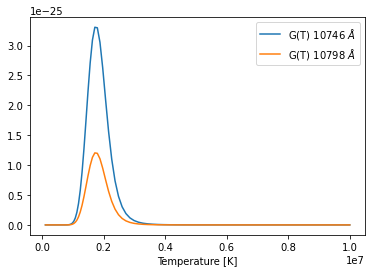

In [14]:
plt.figure()
plt.plot(temps,intensities[0,:] / (edens * 0.85*edens) ,label = r'G(T) 10746 $\AA$')
plt.plot(temps,intensities[1,:] / (edens * 0.85*edens) ,label = r'G(T) 10798 $\AA$')
plt.xlabel('Temperature [K]')
plt.legend()

## Calculate density dependent contribution function 

And now the density dependent contribution function for both 10746 and 10798 with units: 

photons cm$^{+3}$ s$^{-1}$ arcsec$^{-2}$

In [15]:
etemp = fe13.get_maxtemp() 
ht    = 0.1                ## solar radius units above the photosphere 
thetab = 0.                ## degrees 
densities = 10.**np.linspace(6.,12,50)
intensities = np.zeros((2,len(densities)))
alignments = np.zeros((2,len(densities)))

for d,edens in enumerate(densities):
    fe13.calc_rho_sym(edens,etemp,ht, thetab, include_limbdark=True, include_protons=True)
    intensities[0,d] = fe13.calc_Iemiss(10746.)
    intensities[1,d] = fe13.calc_Iemiss(10798.)
    alignments[0,d] = fe13.get_upper_level_alignment(10746.)
    alignments[1,d] = fe13.get_upper_level_alignment(10798.)

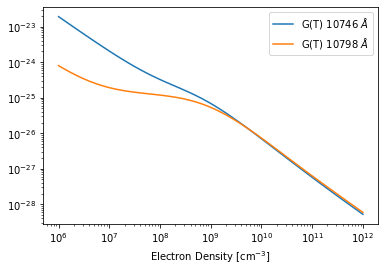

In [16]:
plt.figure()
plt.plot(densities,intensities[0,:] / (densities * 0.85*densities) ,label = r'G(T) 10746 $\AA$')
plt.plot(densities,intensities[1,:] / (densities * 0.85*densities) ,label = r'G(T) 10798 $\AA$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Electron Density [cm$^{-3}$]')
plt.legend()

## Line ratio density dependence for Fe 13 10747 and 10798

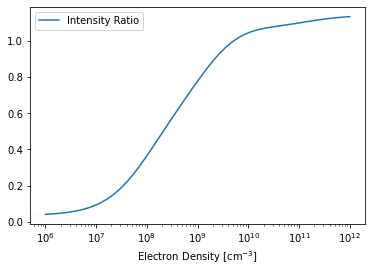

In [17]:
plt.figure()
plt.plot(densities,intensities[1,:] / intensities[0,:] ,label = r'Intensity Ratio')
plt.xscale('log')
plt.xlabel('Electron Density [cm$^{-3}$]')
plt.legend()

## Atomic alignments versus density 

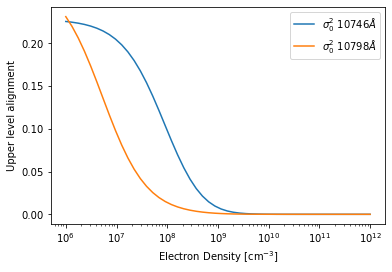

In [18]:
plt.figure()
plt.plot(densities,alignments[0,:] ,label = r'$\sigma_0^2$ $10746 \AA$')
plt.plot(densities,alignments[1,:] ,label = r'$\sigma_0^2$ $10798 \AA$')
plt.xscale('log')
plt.xlabel('Electron Density [cm$^{-3}$]')
plt.ylabel('Upper level alignment')
plt.legend()